In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("poster")
sns.set_style("ticks")

from itertools import chain

from sklearn.metrics import make_scorer
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import RandomizedSearchCV

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import RandomizedSearchCV

import regex as re
from collections import namedtuple, defaultdict, Counter, OrderedDict
from IPython.display import display
from joblib import load, dump, Parallel, delayed

import os, string, sys

from gensim.models import word2vec

In [2]:
class RegexFeatures(object):
    PATTERNS = {
        "isInitCapitalWord": re.compile(r'^[A-Z][a-z]+'),
        "isAllCapitalWord": re.compile(r'^[A-Z][A-Z]+$'),
        "isAllSmallCase": re.compile(r'^[a-z]+$'),
        "isWord": re.compile(r'^[a-zA-Z][a-zA-Z]+$'),
        "isAlphaNumeric": re.compile(r'^\p{Alnum}+$'),
        "isSingleCapLetter": re.compile(r'^[A-Z]$'),
        "containsDashes": re.compile(r'.*--.*'),
        "containsDash": re.compile(r'.*\-.*'),
        "singlePunctuation": re.compile(r'^\p{Punct}$'),
        "repeatedPunctuation": re.compile(r'^[\.\,!\?"\':;_\-]{2,}$'),
        "singleDot": re.compile(r'[.]'),
        "singleComma": re.compile(r'[,]'),
        "singleQuote": re.compile(r'[\']'),
        "isSpecialCharacter": re.compile(r'^[#;:\-/<>\'\"()&]$'),
        "fourDigits": re.compile(r'^\d\d\d\d$'),
        "isDigits": re.compile(r'^\d+$'),
        "isNumber": re.compile(r'^((\p{N}{,2}([,]?\p{N}{3})+)(\.\p{N}+)?)$'),
        "containsDigit": re.compile(r'.*\d+.*'),
        "endsWithDot": re.compile(r'\p{Alnum}+\.$'),
        "isURL": re.compile(r'^http[s]?://'),
        "isMention": re.compile(r'^(RT)?@[\p{Alnum}_]+$'),
        "isHashtag": re.compile(r'^#\p{Alnum}+$'),
        "isMoney": re.compile(r'^\$((\p{N}{,2}([,]?\p{N}{3})+)(\.\p{N}+)?)$'),
    }
    def __init__(self):
        print "Initialized RegexFeature"
    @staticmethod
    def process(word):
        features = dict()
        for k, p in RegexFeatures.PATTERNS.iteritems():
            if p.match(word):
                features[k] = True
        return features
    
    
def classification_report_to_df(report):
    report_list = []
    for i, line in enumerate(report.split("\n")):
        if i == 0:
            report_list.append(["class", "precision", "recall", "f1-score", "support"])
        else:
            line = line.strip()
            if line:
                if line.startswith("avg"):
                    line = line.replace("avg / total", "avg/total")
                line = re.split(r'\s+', line)
                report_list.append(tuple(line))
    return pd.DataFrame(report_list[1:], columns=report_list[0])


DATA_DIR="data/data/"
CLEANED_DIR="data/cleaned/"

Tag = namedtuple("Tag", ["token", "tag"])

def load_sequences(filename, sep="\t", notypes=False, test_data=False):
    sequences = []
    with open(filename) as fp:
        seq = []
        for line in fp:
            line = line.strip()
            if line:
                line = line.split(sep)
                if test_data:
                    assert len(line) == 1
                    line.append("?")
                if notypes:
                    line[1] = line[1][0]
                seq.append(Tag(*line))
            else:
                sequences.append(seq)
                seq = []
        if seq:
            sequences.append(seq)
    return sequences


def load_vocab(filename):
    vocab = set()
    with open(filename) as fp:
        for line in fp:
            line = line.strip()
            vocab.add(line)
    return vocab      

    
def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))
        
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr)) 
        
        
def plot_cm(y_test, y_pred, labels=[], axis=1):
    labels_s = dict((k,i) for i,k in enumerate(labels))
    cm = np.zeros((len(labels), len(labels)))
    for i,j in zip(sum(y_test, []), sum(y_pred, [])):
        i = labels_s[i]
        j = labels_s[j]
        cm[i,j] += 1
    with plt.rc_context(rc={'xtick.labelsize': 12, 'ytick.labelsize': 12,
                       'figure.figsize': (16,14)}):
        sns.heatmap(cm * 100/ cm.sum(axis=axis, keepdims=True),
                    #cmap=sns.cubehelix_palette(n_colors=100, rot=-.4, as_cmap=True),
                    cmap="Greys",
                    xticklabels=labels,
                    yticklabels=labels)
        plt.ylabel("True labels")
        plt.xlabel("Predicted labels")
        title = "Precision Plot"
        if axis== 0:
            title = "Recall Plot"
        plt.title(title)
    print cm.shape
    return cm


def print_sequences(sequences, predictions, filename, test_data=False, notypes=False):
    with open(filename, "wb+") as fp:
        for seq, pred in zip(sequences, predictions):
            for t, p in zip(seq, pred):
                token, tag = t
                if tag[0] == "U":
                    tag = "B%s" % tag[1:]
                if tag[0] == "E":
                    tag = "I%s" % tag[1:]
                if p[0] == "U":
                    p = "B%s" % p[1:]
                if p[0] == "E":
                    p = "I%s" % p[1:]
                if notypes:
                    tag = tag[0]
                    p = p[0]
                if test_data:
                    line = "\t".join((token, p))
                else:
                    line = "\t".join((token, tag, p))
                print >> fp, line
            print >> fp, ""
    print "Done"

In [3]:
WORD_SPLITTER = re.compile(r'[\p{Punct}\s]+')
class DictionaryFeatures:
    def __init__(self, dictDir):
        self.word2dictionaries = {}
        self.word2hashtagdictionaries = {}
        self.dictionaries = []
        i = 0
        for d in os.listdir(dictDir):
            print >> sys.stderr, "read dict %s"%d
            self.dictionaries.append(d)
            if d == '.svn':
                continue
            for line in open(dictDir + "/" + d):
                word = line.rstrip('\n')
                word = word.strip(' ').lower()
                word = WORD_SPLITTER.sub(" ", word)
                word_hashtag = "".join(WORD_SPLITTER.split(word))
                if not self.word2dictionaries.has_key(word):
                    self.word2dictionaries[word] = str(i)
                else:   
                    self.word2dictionaries[word] += "\t%s" % i
                if not self.word2hashtagdictionaries.has_key(word_hashtag):
                    self.word2hashtagdictionaries[word_hashtag] = str(i)
                else:
                    self.word2hashtagdictionaries[word_hashtag] += "\t%s" % i
            i += 1
    
    MAX_WINDOW_SIZE=6
    def GetDictFeatures(self, words, i):
        features = []
        phrase = ' '.join(words[i:i+1]).lower().strip(string.punctuation)
        phrase = WORD_SPLITTER.sub(" ", phrase)
        if self.word2dictionaries.has_key(phrase):
            for j in self.word2dictionaries[phrase].split('\t'):
                features.append('DICT=%s' % self.dictionaries[int(j)])
        for window in range(1, self.MAX_WINDOW_SIZE+1):
            ## Forward
            start=i
            end =i + window + 1
            if start > -1 and end < len(words) + 1:
                phrase = ' '.join(words[start:end]).lower().strip(string.punctuation)
                phrase = WORD_SPLITTER.sub(" ", phrase)
                if self.word2dictionaries.has_key(phrase):
                    for j in self.word2dictionaries[phrase].split('\t'):
                        features.append('DICTFWD[+%s]=%s' % (window, self.dictionaries[int(j)]))
            ## Backward
            start = i - window
            end =i+1
            if start > -1 and end < len(words) + 1:
                phrase = ' '.join(words[start:end]).lower().strip(string.punctuation)
                phrase = WORD_SPLITTER.sub(" ", phrase)
                if self.word2dictionaries.has_key(phrase):
                    for j in self.word2dictionaries[phrase].split('\t'):
                        features.append('DICTBCK[-%s]=%s' % (window, self.dictionaries[int(j)]))
            ## Window        
            start = i - window
            end =i+window+1
            if start > -1 and end < len(words) + 1:
                phrase = ' '.join(words[start:end]).lower().strip(string.punctuation)
                phrase = WORD_SPLITTER.sub(" ", phrase)
                if self.word2dictionaries.has_key(phrase):
                    for j in self.word2dictionaries[phrase].split('\t'):
                        features.append('DICTWIN[%s]=%s' % (window, self.dictionaries[int(j)]))
                        
        """
        for window in range(1,self.MAX_WINDOW_SIZE):
            start=max(i-window+1, 0)
            end = start + window
            phrase = ' '.join(words[start:end]).lower().strip(string.punctuation)
            phrase = WORD_SPLITTER.sub(" ", phrase)
            if self.word2dictionaries.has_key(phrase):
                for j in self.word2dictionaries[phrase].split('\t'):
                    features.append('DICT=%s' % self.dictionaries[int(j)])
                    if window > 1:
                        features.append('DICTWIN[%s]=%s' % (window, self.dictionaries[int(j)]))
                        
        """                
        return list(set(features))
    
    def GetHashtagDictFeatures(self, word):
        features = []
        if len(word) < 2 or word[0] != "#":
            return features
        word = word[1:].lower().strip(string.punctuation)
        if self.word2hashtagdictionaries.has_key(word):
            for j in self.word2hashtagdictionaries[word].split('\t'):
                features.append('DICT_HASHTAG=%s' % self.dictionaries[int(j)])
        return list(set(features))


In [4]:
train_sequences = load_sequences("data/cleaned/train.BIEOU.tsv", sep="\t", notypes=False)
dev_sequences = (load_sequences("data/cleaned/dev.BIEOU.tsv", sep="\t", notypes=False) 
                 + load_sequences("data/cleaned/dev_2015.BIEOU.tsv", sep="\t", notypes=False))
test_sequences = load_sequences("data/cleaned/test.BIEOU.tsv", sep="\t", notypes=False)
vocab = load_vocab("vocab.no_extras.txt")
print len(vocab)

8023


In [5]:
all_sentences = [[t[0] for t in seq] for seq in (train_sequences+dev_sequences)]

In [6]:
other_entities = {
    "isHashtag": [],
    "isMention": [],
    "isURL": [],
    "isMoney": [],
    "isNumber": [],
    "repeatedPunctuation": []
}
for seq in all_sentences:
    for t in seq:
        for k in other_entities.keys():
            if RegexFeatures.PATTERNS[k].match(t):
                other_entities[k].append(t)
for k, v in other_entities.iteritems():
    print k, len(v)

isHashtag 1002
isMoney 8
repeatedPunctuation 1388
isURL 1159
isMention 2243
isNumber 393


In [7]:
ENTITY_MAPPINGS={k: "__%s__" % k for k in other_entities.keys()}
ENTITY_MAPPINGS

{'isHashtag': '__isHashtag__',
 'isMention': '__isMention__',
 'isMoney': '__isMoney__',
 'isNumber': '__isNumber__',
 'isURL': '__isURL__',
 'repeatedPunctuation': '__repeatedPunctuation__'}

In [8]:
def preprocess_token(x, to_lower=False):
    for k in ENTITY_MAPPINGS.keys():
        if RegexFeatures.PATTERNS[k].match(x):
            return ENTITY_MAPPINGS[k]
    if to_lower:
        x = x.lower()
    return x

In [9]:
word2vec_sentences = [[preprocess_token(t[0], to_lower=True) for t in seq] for seq in (train_sequences+dev_sequences)]

In [10]:
word2vec_sentences[0]

['__isMention__',
 '__isMention__',
 'they',
 'will',
 'be',
 'all',
 'done',
 'by',
 'sunday',
 'trust',
 'me',
 '*wink*']

In [11]:
preprocess_token("@guild_gamer")

'__isMention__'

In [12]:
model = word2vec.Word2Vec(word2vec_sentences, size=50, window=10, sg=1, hs=0, min_count=1, negative=10, workers=-1, iter=5)

In [13]:
print model.most_similar_cosmul(positive=["guy", "women"], negative=["man"])
print model.most_similar_cosmul(positive=["raining"])

[('woohoo', 1.1921510696411133), ('sense', 1.1719331741333008), ('stuf', 1.1321699619293213), ('magshipping', 1.1089348793029785), ('daughter', 1.0918970108032227), ('workshops', 1.0673930644989014), ('assuming', 1.0667248964309692), ('leo', 1.06049644947052), ('club', 1.045501470565796), ('theyll', 1.04293954372406)]
[('belgium', 0.7511849403381348), ('witty', 0.7426531314849854), ('casse', 0.7351176738739014), ('changed', 0.7312736511230469), ('amendment', 0.7266189455986023), ('extras', 0.7251930236816406), ('purse', 0.7246640920639038), ('niiiiiiiiiight', 0.7233899831771851), ('coolin', 0.7197006940841675), ('unreal', 0.7180455923080444)]


In [14]:
print model.most_similar(positive=["guy", "women"], negative=["man"])
print model.most_similar(positive=["raining"])

[('sense', 0.504571795463562), ('leo', 0.4583566188812256), ('workshops', 0.4541390538215637), ('woohoo', 0.45328351855278015), ('club', 0.4470578134059906), ('astonishing', 0.4353468716144562), ('gods', 0.42191898822784424), ('stuf', 0.41473114490509033), ('rsw', 0.413332462310791), ('ever', 0.40247923135757446)]
[('belgium', 0.5023713707923889), ('witty', 0.4853076934814453), ('casse', 0.4702368378639221), ('changed', 0.46254879236221313), ('amendment', 0.4532393217086792), ('extras', 0.45038753747940063), ('purse', 0.449329674243927), ('niiiiiiiiiight', 0.44678136706352234), ('coolin', 0.43940281867980957), ('unreal', 0.4360924959182739)]


In [15]:
print model.vocab.keys()[:100]

['raining', 'foul', 'dongwoon/hq', 'woods', 'hanging', 'snowing', 'rimutakas', 'otra', 'opener', 'lord', 'regional', 'kalaingar', 'yellow', 'bringing', 'four', 'slooooooots', 'wednesday', 'bugatti', 'greaaaat', 'solid', 'humeur', 'south-west', 'glassy', 'nigh', 'tired', 'katara', 'complainers', '27-', 'kreeg', 'second', 'inanimate', 'errors', 'inglewood', 'boogie', 'contributed', 'roadhouse', 'fossil', 'cars', 'increasing', 'jessum', 'hero', 'dahl', 'legendary/novelties', 'suga', 'here', 'onga', 'reported', 'china', 'kids', 'elaborate', 'reports', 'chewables', "i'd", 'military', "i'm", 'golden', 'replace', 'brought', 'motoland', 'txt', 'unit', 'dna', 'spoke', '42', 'overshadow', 'explorers', 'dnt', 'gabourey', 'music', 'telegraph', 'strike', 'musik', 'until', 'playboy', 'holy', 'relax', 'successful', 'brings', 'miren', 'yahoo', 'hurt', '99', 'glass', 'thinkpad', '90', '93', 'hold', '94', 'hola', 'hayfever/headcold/sinusinfection', 'listenin', 'wippenberg', 'blade', 'casitas', 'temperat

In [16]:
len(model.vocab)

10092

In [17]:
for k,v in sorted(model.vocab.iteritems(), key=lambda x: x[1].count, reverse=True)[:10]:
    print k, v.count

__isMention__ 2243
. 2118
, 1441
the 1431
__repeatedPunctuation__ 1388
: 1354
i 1216
to 1189
__isURL__ 1159
a 1015


In [18]:
model.vocab.values()[0].count

2

In [19]:
model.similar_by_word("raining")

[('belgium', 0.5023713707923889),
 ('witty', 0.4853076934814453),
 ('casse', 0.4702368378639221),
 ('changed', 0.46254879236221313),
 ('amendment', 0.4532393217086792),
 ('extras', 0.45038753747940063),
 ('purse', 0.449329674243927),
 ('niiiiiiiiiight', 0.44678136706352234),
 ('coolin', 0.43940281867980957),
 ('unreal', 0.4360924959182739)]

In [20]:
model["raining"]

array([ 0.00251598, -0.00186065, -0.00985688, -0.00552237,  0.00261794,
       -0.00577983,  0.00162547, -0.00306061,  0.00332804, -0.00720967,
        0.00692851,  0.00251646, -0.00720343,  0.00313723,  0.00691626,
       -0.00916594,  0.00503378,  0.00781422,  0.00885693, -0.00727555,
        0.00305824,  0.00492674, -0.00703523, -0.00974156, -0.00822543,
        0.00263465, -0.00116582, -0.00107611,  0.00336891,  0.00732394,
       -0.00336881,  0.00855461,  0.00243005, -0.00205823,  0.00868445,
        0.00560661, -0.00610446, -0.00044921, -0.0018357 , -0.0064352 ,
       -0.00039243, -0.00748058, -0.00996461,  0.00338018, -0.00744658,
       -0.00885487,  0.00690349, -0.00815806,  0.00835999,  0.00440392], dtype=float32)

## Glove mappings

In [21]:
GLOVE_TWEET_MAPPINGS={
    "<user>": "isMention",
    "<hashtag>": "isHashtag",
    "<number>": "isDigit",
    "<url>": "isURL",
    "<allcaps>": "isAllCapitalWord",
}

def process_glovevectors(filename):
    words, dim = 0, 0
    with open(filename) as fp:
        for line in fp:
            #line = line.strip().split(" ")
            words+= 1
    line = line.strip().split(" ")
    dim = len(line) - 1
    print "Words: {}, dim: {}".format(words, dim)
    with open(filename) as fp, open("{}.processed.txt".format(filename), "wb+") as fp1:
        print >> fp1, words, dim
        for line in fp:
            line = line.strip().split(" ", 1)
            line[0] = dict.get(GLOVE_TWEET_MAPPINGS, line[0], line[0])
            print >> fp1, line[0], line[1]
    print "Done"
        

## Uncomment this cell to re-process glove vectors

```
process_glovevectors("/home/entity/Downloads/GloVe/glove.twitter.27B.200d.txt")
"""
Words: 1193514, dim: 50
Done
"""
```

In [22]:
model_glove = word2vec.Word2Vec(word2vec_sentences, size=200, window=10, sg=1, hs=0, min_count=1, negative=10, workers=-1, iter=5)

In [23]:
model_glove.intersect_word2vec_format("/home/entity/Downloads/GloVe/glove.twitter.27B.200d.txt.processed.txt", binary=False)

In [24]:
#for i in xrange(5):
#   model_glove.train(word2vec_sentences, total_examples=len(word2vec_sentences))

In [25]:
print model_glove.most_similar_cosmul(positive=["king", "women"], negative=["man"])
print model_glove.most_similar_cosmul(positive=["raining"])

[('queen', 0.8635461926460266), ('prince', 0.8147591352462769), ('kings', 0.8053630590438843), ('african', 0.8034176826477051), ('collection', 0.798965334892273), ('princess', 0.7982502579689026), ('national', 0.7926250696182251), ('queens', 0.7904216647148132), ('our', 0.7895063757896423), ('olympic', 0.7883802652359009)]
[('snowing', 0.9088315367698669), ('rain', 0.8637869358062744), ('pouring', 0.831719160079956), ('rains', 0.828848659992218), ('rainy', 0.8258071541786194), ('cold', 0.8168103098869324), ('snow', 0.8152739405632019), ('outside', 0.8126229643821716), ('weather', 0.8116412162780762), ('degrees', 0.7995356917381287)]


In [26]:
print model_glove.most_similar(positive=["king", "women"], negative=["man"])
print model_glove.most_similar(positive=["raining"])

[('queen', 0.5662634968757629), ('prince', 0.5070953965187073), ('kings', 0.48121270537376404), ('african', 0.4752596914768219), ('ladies', 0.4659445583820343), ('princess', 0.4627862870693207), ('collection', 0.4574243724346161), ('our', 0.4551507234573364), ('black', 0.4548451900482178), ('national', 0.4532495439052582)]
[('snowing', 0.8176649212837219), ('rain', 0.7275756001472473), ('pouring', 0.6634398698806763), ('rains', 0.6576988101005554), ('rainy', 0.6516158580780029), ('cold', 0.6336221098899841), ('snow', 0.630549430847168), ('outside', 0.6252474188804626), ('weather', 0.6232839822769165), ('degrees', 0.5990728735923767)]


## Label correlations

In [27]:
label_co_occurences = [[t[1][2:] for t in seq if t[1] != "O"] for seq in (train_sequences)]

In [28]:
cat_types = Counter(t for seq in label_co_occurences for t in seq)
cat_ids = {k[0]: i for i, k in enumerate(cat_types.most_common())}
cat_names = [k[0] for k in cat_types.most_common()]
print cat_ids
print cat_types

{'product': 5, 'facility': 3, 'movie': 7, 'company': 4, 'sportsteam': 8, 'musicartist': 6, 'person': 0, 'other': 1, 'geo-loc': 2, 'tvshow': 9}
Counter({'person': 664, 'other': 545, 'geo-loc': 325, 'facility': 209, 'company': 207, 'product': 177, 'musicartist': 116, 'movie': 80, 'sportsteam': 74, 'tvshow': 65})


## Label specific vectors

In [29]:
def get_non_label_words(t):
    if t[1] != "O":
        return "LABEL-{}".format(t[1][1:])
    return preprocess_token(t[0], to_lower=True)

In [30]:
label_specific_sentences = [[get_non_label_words(t) for t in seq] for seq in (train_sequences)]

In [31]:
model_label_specific = word2vec.Word2Vec(label_specific_sentences,
                                         size=200, window=10, sg=1, hs=0, min_count=1, negative=10, workers=-1, iter=20)

In [32]:
model_label_specific.most_similar("LABEL-product")

[('whom', 0.26011449098587036),
 ('compared', 0.2354053258895874),
 ('generating', 0.22560346126556396),
 ('killed', 0.22056034207344055),
 ('boi', 0.21400517225265503),
 ('theater', 0.21115969121456146),
 ('la', 0.21090877056121826),
 ('ld', 0.20020538568496704),
 ('fights', 0.20011185109615326),
 ('where', 0.19708320498466492)]

In [33]:
import copy

In [34]:
model_label_specific.intersect_word2vec_format("/home/entity/Downloads/GloVe/glove.twitter.27B.200d.txt.processed.txt",
                                               binary=False)
for i in xrange(5):
    model_label_specific.train(label_specific_sentences, total_examples=len(label_specific_sentences))

In [35]:
model_label_specific.most_similar("LABEL-sportsteam")

[('soup', 0.26856234669685364),
 ('dishes', 0.26497727632522583),
 ('workz', 0.2624945640563965),
 ('flowing', 0.25266361236572266),
 ('persian', 0.2509954571723938),
 ('mixing', 0.24889320135116577),
 ('oily', 0.23985573649406433),
 ('dry', 0.2286411076784134),
 ('english', 0.22728340327739716),
 ('puking', 0.22508037090301514)]

## Cluster word embeddings

In [36]:
from sklearn.cluster import AgglomerativeClustering

In [37]:
wv_clusters = AgglomerativeClustering(n_clusters=50, affinity="cosine", linkage="average")

In [38]:
wv_clusters.fit(model_label_specific.syn0norm)

AgglomerativeClustering(affinity='cosine', compute_full_tree='auto',
            connectivity=None, linkage='average',
            memory=Memory(cachedir=None), n_clusters=50, n_components=None,
            pooling_func=<function mean at 0x7f8f3c207cf8>)

In [39]:
wv_cluster_ids = wv_clusters.fit_predict(model_label_specific.syn0norm)

In [40]:
wv_cluster_mappings = {k: wv_cluster_ids[v.index] for k,v in model_label_specific.vocab.iteritems()}

In [41]:
filter(lambda x: x[1] == 4, wv_cluster_mappings.iteritems())[:10]

[('*sighs*', 4),
 ('co-ass', 4),
 ('eyes*wat', 4),
 ('25%', 4),
 ('radio.woai.com', 4),
 ('104&amp;#xb0', 4),
 ("g'mar", 4),
 ('i`ll', 4),
 ('(shit', 4),
 ('p-i-m-p', 4)]

In [42]:
del model_label_specific

## Word clusters - Brown and Clark

In [43]:
def read_brown_clusters(filename):
    cluster_vocab={}
    with open(filename) as fp:
        for line in fp:
            cid, word, counts = line.strip().split("\t")
            cluster_vocab[word] = cid
    return cluster_vocab       
        
    
def read_clark_clusters(filename):
    cluster_vocab={}
    with open(filename) as fp:
        for line in fp:
            try:
                word, cid, prob = line.strip().split(" ")
                cluster_vocab[word] = (cid, float(prob))
            except:
                print "skipping line: ", line
    return cluster_vocab

In [44]:
cluster_vocab = read_brown_clusters("/home/entity/Downloads/GloVe/50mpaths2")

## Run once for creating data for brown clusters

In [45]:
with open("all_sequences.txt", "wb+") as fp:
    for seq in all_sentences:
        print >> fp, " ".join(seq)
! head all_sequences.txt

@SammieLynnsMom @tg10781 they will be all done by Sunday trust me *wink*
Made it back home to GA . It sucks not to be at Disney world , but its good to be home . Time to start planning the next Disney World trip .
' Breaking Dawn ' Returns to Vancouver on January 11th http://bit.ly/dbDMs8
@ls_n perhaps , but folks may find something in the gallery that is helpful in their day-to-day work as well . Even just to use it .
@Carr0t aye been tonight - excellent
RT @LilTwist : RT this if you want me to go back live on Ustream later tonight
@Hollly_ 16 b 17 in feb
RT @obsidianchao : OF FUCKING COURSE . I GET HOME AND MY BROTHER IS ON THE MOTHER FUCKING XBOX . Worst fucking day ever .
I haven't driven to bc in years , and I am just stunned by how beautiful the drive is .
@daraobriain hmmm . Cant wait . Comin on Thursday . First time to the Apollo .


In [46]:
! /home/entity/Downloads/brown-cluster/wcluster --text all_sequences.txt --c 100 --output_dir word_clusters

Logging to word_clusters/log


In [47]:
with open("word2vec_sentences.txt", "wb+") as fp:
    for seq in word2vec_sentences:
        print >> fp, " ".join(seq)
! head word2vec_sentences.txt

__isMention__ __isMention__ they will be all done by sunday trust me *wink*
made it back home to ga . it sucks not to be at disney world , but its good to be home . time to start planning the next disney world trip .
' breaking dawn ' returns to vancouver on january 11th __isURL__
__isMention__ perhaps , but folks may find something in the gallery that is helpful in their day-to-day work as well . even just to use it .
__isMention__ aye been tonight - excellent
rt __isMention__ : rt this if you want me to go back live on ustream later tonight
__isMention__ 16 b 17 in feb
rt __isMention__ : of fucking course . i get home and my brother is on the mother fucking xbox . worst fucking day ever .
i haven't driven to bc in years , and i am just stunned by how beautiful the drive is .
__isMention__ hmmm . cant wait . comin on thursday . first time to the apollo .


In [48]:
! /home/entity/Downloads/brown-cluster/wcluster --text word2vec_sentences.txt --c 100 --output_dir word_clusters_wv

Logging to word_clusters_wv/log


## Load trained brown clusters

In [49]:
cluster_vocab_data = read_brown_clusters("word_clusters/paths")
cluster_vocab_wv = read_brown_clusters("word_clusters_wv/paths")

## Run once for generating clark clusters

In [62]:
with open("all_sequences.clark.txt", "wb+") as fp:
    for seq in all_sentences:
        print >> fp, "\n".join(seq)
        print >> fp, "\n"
! head all_sequences.clark.txt

@SammieLynnsMom
@tg10781
they
will
be
all
done
by
Sunday
trust


In [65]:
! /home/entity/Downloads/clark_pos_induction/src/bin/cluster_neyessenmorph -s 10 -m 1 -i 10 -x all_sequences.clark.txt all_sequences.clark.txt 32 > all_sequences.clark_clusters.32.txt 2> clark.err

## Load clark clusters

In [50]:
cluster_vocab_clark = read_clark_clusters("all_sequences.clark_clusters.32.txt")

skipping line:   17 0.955895



## Read dictionary features

In [51]:
dict_features = DictionaryFeatures("./data/cleaned/custom_lexicons/")

read dict time.holiday
read dict location.country
read dict award.award
read dict location
read dict movies.txt.results.txt
read dict lastname.5000
read dict sports.sports_team
read dict tv.tv_program
read dict book.newspaper
read dict internet.website
read dict base.events.festival_series
read dict products.txt.results.txt
read dict persons.txt.results.txt
read dict tv.tv_network
read dict cvg.computer_videogame
read dict business.consumer_product
read dict people.family_name
read dict tvshows.txt.results.txt
read dict government.government_agency
read dict venues
read dict broadcast.tv_channel
read dict music_artists.txt.results.txt
read dict automotive.make
read dict product
read dict business.consumer_company
read dict music_artists.txt
read dict venture_capital.venture_funded_company
read dict cvg.cvg_developer
read dict architecture.museum
read dict lower.5000
read dict automotive.model
read dict companynames.txt.results.txt
read dict musicartist_namevariants.unique.txt
read dict

## Predict tweet type

In [52]:
def tweet_features(sent, word2vec_model=None, cluster_vocabs=None, WORD_IDX=0):
    features = {}
    sent_length = len(sent) * 1.
    for widx, word in enumerate(sent):
        word = word[WORD_IDX]
        lookup_key = preprocess_token(word, to_lower=True)
        if word2vec_model and lookup_key in word2vec_model:
            for i,v in enumerate(word2vec_model[lookup_key]):
                features["_GLOBAL_WORDVEC_%s" % i] = dict.get(features, "_GLOBAL_WORDVEC_%s" % i, 0) + v
        if cluster_vocabs and lookup_key in cluster_vocabs:
            v = dict.get(cluster_vocabs, lookup_key)
            features["_GLOBAL_CLUSTER_=%s" % v] = dict.get(features, "_GLOBAL_CLUSTER_=%s" % v, 0) + 1
        if dict_features:
            d_features = dict_features.GetDictFeatures([k[WORD_IDX] for k in sent], widx)
            for k in d_features:
                features[k] = dict.get(features, k, 0) + 1
            d_hashtag_features = dict_features.GetHashtagDictFeatures(word)
            for k in d_hashtag_features:
                features[k] = dict.get(features, k, 0) + 1
    #features = {k: v / sent_length for k,v in features.iteritems()}
    return features

In [53]:
from sklearn.feature_extraction import DictVectorizer

In [65]:
tweet_train_data = [tweet_features(sent, word2vec_model=model_glove, cluster_vocabs=cluster_vocab)
                   for sent in train_sequences]
tweet_test_data = [tweet_features(sent, word2vec_model=model_glove, cluster_vocabs=cluster_vocab)
                   for sent in dev_sequences]
tweet_test_final_data = [tweet_features(sent, word2vec_model=model_glove, cluster_vocabs=cluster_vocab)
                   for sent in test_sequences]

In [66]:
feature2matrix = DictVectorizer()
tweet_X_train = feature2matrix.fit_transform(tweet_train_data)
tweet_X_test = feature2matrix.transform(tweet_test_data)
tweet_X_test_final = feature2matrix.transform(tweet_test_final_data)

In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC

In [68]:
def is_tweet_type(sent, cat_type):
    for t in sent:
        if t.tag != "O":
            if t.tag[2:] == cat_type:
                return 1
    return 0
            

In [69]:
models = {}
for cat_type in cat_names:
    print "Processing: %s" % cat_type
    y_train = np.array([is_tweet_type(sent, cat_type) for sent in train_sequences])
    y_test = np.array([is_tweet_type(sent, cat_type) for sent in dev_sequences])
    model = LogisticRegression(solver="lbfgs", multi_class="multinomial")
    model.fit(tweet_X_train, y_train)
    y_pred = model.predict(tweet_X_test)
    print classification_report(y_test, y_pred)
    models[cat_type] = model

Processing: person
             precision    recall  f1-score   support

          0       0.94      0.93      0.93      1231
          1       0.56      0.58      0.57       189

avg / total       0.89      0.88      0.89      1420

Processing: other
             precision    recall  f1-score   support

          0       0.91      0.90      0.90      1255
          1       0.29      0.32      0.30       165

avg / total       0.84      0.83      0.83      1420

Processing: geo-loc
             precision    recall  f1-score   support

          0       0.96      0.94      0.95      1297
          1       0.48      0.61      0.54       123

avg / total       0.92      0.91      0.91      1420

Processing: facility
             precision    recall  f1-score   support

          0       0.98      0.96      0.97      1375
          1       0.21      0.31      0.25        45

avg / total       0.95      0.94      0.95      1420

Processing: company
             precision    recall  f1-score

In [70]:
model.predict_proba(tweet_X_test)[:10, 1]

array([  3.42877844e-02,   1.41197353e-03,   1.61901138e-01,
         9.96124170e-01,   1.80556124e-01,   3.81964705e-06,
         1.16778507e-03,   2.03262332e-06,   2.05595303e-02,
         4.32040855e-05])

In [71]:
model.predict(tweet_X_test)[:10]

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

## Model

In [72]:
def get_word_form(word, vocab=None, lower=False):
    if lower:
        word = word.lower()
    if vocab:
        vocab_search_word = word.lower() 
        word = "OOV" if vocab_search_word not in vocab else word
    return word

def get_clust_tag_value(lookup_key, cluster_vocab, cluster_tag,
                       clust_values_tuple=False):
    v = cluster_vocab[lookup_key]
    if clust_values_tuple:
        cluster_tag = "{}={}".format(cluster_tag, v[0])
        v = v[1]
    return (cluster_tag, v)    


def gen_cluster_features(sent, widx, cid, lookup_key, cluster_vocab, WORD_IDX=0, 
                         cluster_tag="_CLUST_", dropout=0, clust_values_tuple=False,
                        interactions=False):
    features = {}
    if lookup_key in cluster_vocab:
        center_word_f = get_clust_tag_value(lookup_key, cluster_vocab,
                                            cluster_tag, clust_values_tuple=clust_values_tuple)
        features.setdefault(*center_word_f)
        ## Previous word
        if widx > 0:
            lookup_key_prev = preprocess_token(sent[widx-1][WORD_IDX], to_lower=True)
            if lookup_key_prev in cluster_vocab:
                prev_word_f = get_clust_tag_value(lookup_key_prev, cluster_vocab, 
                                                 "{}[-1]".format(cluster_tag),
                                                  clust_values_tuple=clust_values_tuple)
                features.setdefault(*prev_word_f)
                if interactions:
                    if np.random.rand() > dropout:
                        if clust_values_tuple:
                            features["{}|{}".format(
                                    center_word_f[0], prev_word_f[0]
                                )] = (center_word_f[1]*prev_word_f[1])
                        else:
                            features["{}={}|{}={}".format(*(center_word_f+prev_word_f))] = True
        ## Next word
        if widx < len(sent) -1:
            lookup_key_next = preprocess_token(sent[widx+1][WORD_IDX], to_lower=True)
            if lookup_key_next in cluster_vocab:
                next_word_f = get_clust_tag_value(lookup_key_next, cluster_vocab, 
                                                 "{}[+1]".format(cluster_tag),
                                                 clust_values_tuple=clust_values_tuple)
                features.setdefault(*next_word_f)
                if interactions:
                    if np.random.rand() > dropout:
                        if clust_values_tuple:
                            features["{}|{}".format(
                                    next_word_f[0], center_word_f[0]
                                )] = (next_word_f[1]*center_word_f[1])
                        else:
                            features["{}={}|{}={}".format(*(next_word_f+center_word_f))] = True
        """
        for k,v in features.iteritems():
            if isinstance(v, float) or isinstance(v, bool) or isinstance(v, str) or isinstance(v,int):
                continue
            else:
                print features
                print k,v
                raise
        """
        return features
    

def word2features(sent, widx, WORD_IDX=0,
                  extra_features={},
                  vocab=None, dict_features=None,
                  vocab_presence_only=False,
                  dict_interactions=False,
                  interactions=False,
                  lowercase=True,
                  window=0,
                 verbose=False, dropout=0.5,
                 word2vec_model=None,
                 cluster_vocabs=None):
    word = sent[widx][WORD_IDX]
    features = {
        'bias': True,
        #'word_normed': word.lower(),
        #'suffix_3': word[-3:].lower(),
        #'suffix_2': word[-2:].lower(),
        #'prefix_3': word[-3:].lower(),
        #'prefix_2': word[-2:].lower(),
    }
    ## Word2Vec or Brown Cluster features
    if word2vec_model or cluster_vocabs:
        lookup_key = preprocess_token(word, to_lower=True)
        ## Word2Vec features
        if word2vec_model and lookup_key in word2vec_model:
            word2vec_features = {"_WORDVEC_%s" % i: v for i,v in enumerate(word2vec_model[lookup_key])}
            features.update(word2vec_features)
        ## Brown cluster features
        if cluster_vocabs:
            if not isinstance(cluster_vocabs, list):
                cluster_vocabs = [cluster_vocabs]
            for cid, cluster_vocab in enumerate(cluster_vocabs):
                cluster_type="BROWN"
                if cluster_vocab:
                    clust_values_tuple=False
                    if isinstance(cluster_vocab.itervalues().next(), tuple):
                        clust_values_tuple = True
                        cluster_type="CLARK"
                    cluster_tag = "__{}_CLUSTER_{}__".format(cluster_type, cid)
                    clust_features = gen_cluster_features(
                        sent, widx, cid, lookup_key, cluster_vocab, WORD_IDX=WORD_IDX,
                        cluster_tag=cluster_tag, dropout=dropout, 
                        clust_values_tuple=clust_values_tuple, interactions=interactions)
                    if clust_features:
                        features.update(clust_features)

    ## Vocab Feature
    if vocab:
        if vocab_presence_only:
            features["word_normed"] = word.lower() in vocab
        else:
            features["word_normed"] = word.lower() if word.lower() in vocab else "OOV"
    ## Regex Feature
    regex_features = RegexFeatures.process(word)
    features.update(regex_features)
    if interactions:
        if widx > 0:
            regex_features_prev = RegexFeatures.process(sent[widx-1][WORD_IDX])
            features.update(("%s[-1]" % k, v) for k,v in regex_features_prev.iteritems())
            features.update({
                    ("%s[-1]|%s" % (k1,k), True)
                    for k, v in regex_features.iteritems()
                    for k1, v1 in regex_features_prev.iteritems()
                    if v & v1 & (np.random.rand() > dropout)
                })
        if widx < len(sent)-1:
            regex_features_next = RegexFeatures.process(sent[widx+1][WORD_IDX])
            features.update(("%s[+1]" % k, v) for k,v in regex_features_next.iteritems())
            features.update({
                    ("%s|%s[+1]" % (k,k1), True)
                    for k, v in regex_features.iteritems()
                    for k1, v1 in regex_features_next.iteritems()
                    if v & v1 & (np.random.rand() > dropout)
                })
    ## Gazetteer Feature
    if dict_features:
        d_features = dict_features.GetDictFeatures([k[WORD_IDX] for k in sent], widx)
        features.update({k: True for k in d_features})
        d_features = sorted(d_features)
        features.update({"%s|%s" % (k,k1): True for i, k in enumerate(d_features)
                         for k1 in d_features[i+1:]
                         if np.random.rand() > dropout})
        d_hashtag_features = dict_features.GetHashtagDictFeatures(word)
        features.update({k: True for k in d_hashtag_features})
        d_hashtag_features = sorted(d_hashtag_features)
        features.update({"%s|%s" % (k,k1): True for i, k in enumerate(d_hashtag_features)
                         for k1 in d_hashtag_features[i+1:]
                         if np.random.rand() > dropout})
    ## Extra features
    features.update(extra_features)
    ## Start Feature
    if widx == 0:
        features['__BOS__'] = True
    ## End Feature
    if widx == len(sent)-1:
        features['__EOS__'] = True
    ## Word Feature
    if not lowercase:
        if np.random.rand() > dropout:
            features["word_original"] = word
    curr_word_normed = get_word_form(word, lower=lowercase, vocab=vocab)
    #features["normed_word"] = curr_word_normed
    
    """
    if widx > 0:
        prev_word = get_word_form(sent[widx-1][WORD_IDX], lower=lowercase)
        features["word[-1]"] = prev_word
        if interactions:
            if np.random.rand() > dropout:
                features["word[-1]=%s|word=%s" % (prev_word, curr_word_normed)] = True
    if widx < len(sent) -1:
        next_word = get_word_form(sent[widx+1][WORD_IDX], lower=lowercase)
        features["word[+1]"] = next_word
        if interactions:
            if np.random.rand() > dropout:
                features["word[+1]=%s|word=%s" % (next_word, curr_word_normed)] = True
    """
    return features

def sent2features(sent, extra_features=None, **kwargs):
    if extra_features:
        return [word2features(sent, i, extra_features=extra_features[i],
                              **kwargs) for i in range(len(sent))]
    return [word2features(sent, i, **kwargs) for i in range(len(sent))]

def sent2labels(sent, lbl_id=1):
    return [k[lbl_id] for k in sent]

In [73]:
def get_global_sequence_features(sent, word2vec_model=None, cluster_vocabs=None, WORD_IDX=0,
                                 predictions=None):
    features = {}
    sent_length = len(sent) * 1.
    for word in sent:
        word = word[WORD_IDX]
        lookup_key = preprocess_token(word, to_lower=True)
        if word2vec_model and lookup_key in word2vec_model:
            for i,v in enumerate(word2vec_model[lookup_key]):
                features["_GLOBAL_WORDVEC_%s" % i] = dict.get(features, "_GLOBAL_WORDVEC_%s" % i, 0) + v
        if cluster_vocabs and lookup_key in cluster_vocabs:
            v = dict.get(cluster_vocabs, lookup_key)
            features["_GLOBAL_CLUSTER_=%s" % v] = dict.get(features, "_GLOBAL_CLUSTER_=%s" % v, 0) + 1
    features = {k: v / sent_length for k,v in features.iteritems()}
    if predictions:
        for k, prob in predictions.iteritems():
            features["_MODEL_=%s" % k] = prob
    return [features for word in sent]
    

In [74]:
def get_global_predictions(models, X_train):
    predictions = {}
    for k, model in models.iteritems():
        y_pred = model.predict_proba(X_train)[:, 1]
        predictions[k] = y_pred
    keys = predictions.keys()
    predictions = [dict(zip(keys, v)) for v in zip(*predictions.values())]
    return predictions

In [75]:
predictions_train = get_global_predictions(models, tweet_X_train)
predictions_dev = get_global_predictions(models, tweet_X_test)
predictions_test = get_global_predictions(models, tweet_X_test_final)

In [73]:
del upsampled_training_data
del upsampled_predictions_train

In [121]:
%%time
#upsampled_training_data = train_sequences*5
X_train = [sent2features(s, vocab=None,
                         dict_features=dict_features, vocab_presence_only=False,
                         window=2, interactions=True, dict_interactions=False,
                         lowercase=True, dropout=0, word2vec_model=model_glove,
                        cluster_vocabs=[
            cluster_vocab,
            cluster_vocab_clark,
            cluster_vocab_wv
        ],
              #extra_features=get_global_sequence_features(
            #s, cluster_vocabs=cluster_vocab, word2vec_model=model_glove,
        #predictions=p
        #)
        )
           for s, p in zip(train_sequences, predictions_train)]
y_train = [sent2labels(s) for s in train_sequences]

X_test = [sent2features(s, vocab=None,
                         dict_features=dict_features, vocab_presence_only=False,
                         window=2, interactions=True, dict_interactions=False,
                         lowercase=True, dropout=0, word2vec_model=model_glove,
                        cluster_vocabs=[
            cluster_vocab,
            cluster_vocab_clark,
            cluster_vocab_wv
        ],
              #extra_features=get_global_sequence_features(
            #s, cluster_vocabs=cluster_vocab, word2vec_model=model_glove,
        #predictions=p
        #)
        )
          for s, p in zip(dev_sequences, predictions_dev)]
y_test = [sent2labels(s) for s in dev_sequences]
print len(X_train), len(y_train), len(X_test), len(y_test)

2394 2394 1420 1420
CPU times: user 24.3 s, sys: 832 ms, total: 25.2 s
Wall time: 25.2 s


In [76]:
%%time
#upsampled_training_data = train_sequences*5
X_train = [sent2features(s, vocab=None,
                         dict_features=dict_features, vocab_presence_only=False,
                         window=2, interactions=True, dict_interactions=False,
                         lowercase=True, dropout=0, word2vec_model=model_glove,
                        cluster_vocabs=None)
           for s, p in zip(train_sequences, predictions_train)]
y_train = [sent2labels(s) for s in train_sequences]

X_test = [sent2features(s, vocab=None,
                         dict_features=dict_features, vocab_presence_only=False,
                         window=2, interactions=True, dict_interactions=False,
                         lowercase=True, dropout=0, word2vec_model=model_glove,
                        cluster_vocabs=None)
          for s, p in zip(dev_sequences, predictions_dev)]
y_test = [sent2labels(s) for s in dev_sequences]


X_test_final = [sent2features(s, vocab=None,
                         dict_features=dict_features, vocab_presence_only=False,
                         window=2, interactions=True, dict_interactions=False,
                         lowercase=True, dropout=0, word2vec_model=model_glove,
                        cluster_vocabs=None)
          for s, p in zip(test_sequences, predictions_test)]
y_test_final = [sent2labels(s) for s in test_sequences]

print len(X_train), len(y_train), len(X_test), len(y_test), len(X_test_final), len(y_test_final)

2394 2394 1420 1420 3856 3856
CPU times: user 39 s, sys: 1.86 s, total: 40.8 s
Wall time: 40.8 s


## Upscaled sampling

In [61]:
%%time
upsampled_training_data = train_sequences*1
upsampled_predictions_train = predictions_train*1
X_train = [sent2features(s, vocab=None,
                         dict_features=dict_features, vocab_presence_only=False,
                         window=2, interactions=True, dict_interactions=False,
                         lowercase=True, dropout=0.5, word2vec_model=model_glove,
                        cluster_vocabs=[
            cluster_vocab,
            cluster_vocab_clark,
            cluster_vocab_wv
        ],
              extra_features=get_global_sequence_features(
            s, cluster_vocabs=cluster_vocab, word2vec_model=model_glove,
        predictions=p
        ))
           for s, p in zip(upsampled_training_data, upsampled_predictions_train)]
y_train = [sent2labels(s) for s in upsampled_training_data]

X_test = [sent2features(s, vocab=None,
                         dict_features=dict_features, vocab_presence_only=False,
                         window=2, interactions=True, dict_interactions=False,
                         lowercase=True, dropout=0, word2vec_model=model_glove,
                        cluster_vocabs=[
            cluster_vocab,
            cluster_vocab_clark,
            cluster_vocab_wv
        ],
              extra_features=get_global_sequence_features(
            s, cluster_vocabs=cluster_vocab, word2vec_model=model_glove,
        predictions=p
        ))
          for s, p in zip(dev_sequences, predictions_dev)]
y_test = [sent2labels(s) for s in dev_sequences]
#print len(X_train), len(y_train), len(X_test), len(y_test)

CPU times: user 44.8 s, sys: 1.44 s, total: 46.3 s
Wall time: 46.3 s


## Model training

In [77]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='l2sgd', 
    c2=1e-3,
    #max_iterations=100,
    #calibration_samples=20,
    #all_possible_transitions=True,
    #all_possible_states=True
)
crf.fit(X_train, y_train)

CPU times: user 3min 2s, sys: 1.34 s, total: 3min 3s
Wall time: 3min 3s


In [78]:
labels = list(crf.classes_)
labels.remove('O')

# group B and I results
sorted_labels = sorted(
    labels, 
    key=lambda name: (name[1:], name[0])
)

y_pred = crf.predict(X_train)
print "Training accuracy: ", metrics.flat_f1_score(y_train, y_pred, 
                      average='weighted', labels=labels)

report = metrics.flat_classification_report(
    y_train, y_pred, labels=sorted_labels, digits=3
)
display(classification_report_to_df(report))

Training accuracy:  0.824920156493


,class,precision,recall,f1-score,support
0,B-company,1.000,0.815,0.898,27
1,E-company,1.000,0.815,0.898,27
2,I-company,1.000,0.889,0.941,9
3,U-company,0.976,0.833,0.899,144
4,B-facility,0.986,0.899,0.940,79
5,E-facility,0.986,0.897,0.940,78
6,I-facility,1.000,0.962,0.980,26
7,U-facility,1.000,0.615,0.762,26
8,B-geo-loc,0.977,0.956,0.966,45
9,E-geo-loc,0.974,0.950,0.962,40


In [79]:
y_pred = crf.predict(X_test)
print "Dev accuracy: ", metrics.flat_f1_score(y_test, y_pred, 
                      average='weighted', labels=labels)

report = metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
)
display(classification_report_to_df(report))

Dev accuracy: 

/home/entity/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/entity/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


 0.310909559247


/home/entity/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/entity/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


,class,precision,recall,f1-score,support
0,B-company,0.000,0.000,0.000,27
1,E-company,0.000,0.000,0.000,27
2,I-company,0.000,0.000,0.000,14
3,U-company,0.479,0.511,0.495,45
4,B-facility,0.160,0.143,0.151,28
5,E-facility,0.259,0.259,0.259,27
6,I-facility,0.250,0.059,0.095,17
7,U-facility,0.000,0.000,0.000,18
8,B-geo-loc,0.567,0.415,0.479,41
9,E-geo-loc,0.607,0.472,0.531,36


In [80]:
print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(25))

Top likely transitions:
I-other -> E-other 8.326677
I-other -> I-other 8.033766
B-other -> I-other 7.837208
B-person -> E-person 7.352172
B-facility -> E-facility 6.703254
B-other -> E-other 6.689907
O      -> O       6.396305
B-facility -> I-facility 5.967874
B-product -> E-product 5.831560
I-facility -> E-facility 5.813935
B-musicartist -> E-musicartist 5.617387
B-geo-loc -> E-geo-loc 5.009069
B-company -> E-company 4.985373
I-product -> I-product 4.526349
E-person -> O       4.506007
U-person -> O       4.287536
I-product -> E-product 4.226619
O      -> U-person 4.145612
B-sportsteam -> E-sportsteam 4.123253
I-movie -> E-movie 4.110048
B-movie -> E-movie 4.103894
O      -> U-geo-loc 4.078506
B-tvshow -> E-tvshow 3.955884
I-person -> E-person 3.904069
U-other -> O       3.733201


In [81]:
possible_labels = ["%s-%s" % (k1,k) for k in cat_names
    for k1 in ["B", "I", "E", "U"]] + ["O"]
print possible_labels


['B-person', 'I-person', 'E-person', 'U-person', 'B-other', 'I-other', 'E-other', 'U-other', 'B-geo-loc', 'I-geo-loc', 'E-geo-loc', 'U-geo-loc', 'B-facility', 'I-facility', 'E-facility', 'U-facility', 'B-company', 'I-company', 'E-company', 'U-company', 'B-product', 'I-product', 'E-product', 'U-product', 'B-musicartist', 'I-musicartist', 'E-musicartist', 'U-musicartist', 'B-movie', 'I-movie', 'E-movie', 'U-movie', 'B-sportsteam', 'I-sportsteam', 'E-sportsteam', 'U-sportsteam', 'B-tvshow', 'I-tvshow', 'E-tvshow', 'U-tvshow', 'O']


In [82]:
possible_labels.index("O")

40

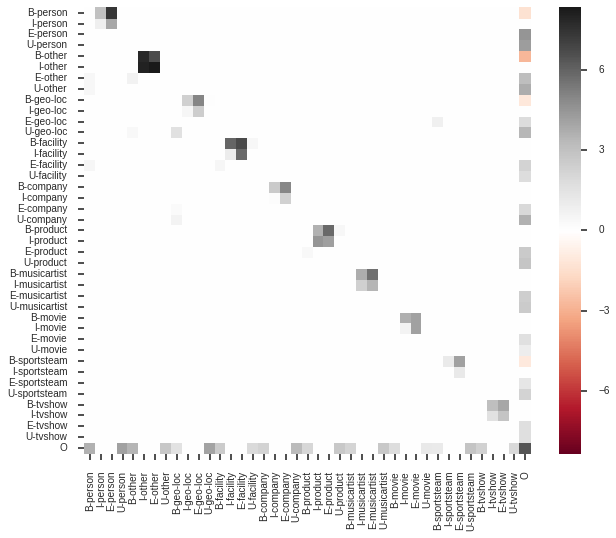

In [83]:
transition_matrix = np.zeros((len(possible_labels), len(possible_labels)))
for k in possible_labels:
    for k1 in possible_labels:
        if (k,k1) in crf.transition_features_:
            i,j = possible_labels.index(k), possible_labels.index(k1)
            transition_matrix[i,j] = crf.transition_features_[(k,k1)]

with plt.rc_context(rc={'xtick.labelsize': 10, 'ytick.labelsize': 10,
                        'font.size': 10,
                       'figure.figsize': (10,8)}):        
    sns.heatmap(data=transition_matrix,
            xticklabels=possible_labels, yticklabels=possible_labels,
           cmap="RdGy")

In [84]:
df_t=[]
for k in cat_names:
    t = max(filter(lambda t: t[0][1][0] != "O" and t[0][1][2:] == k, 
            crf.state_features_.iteritems()), 
        key=lambda x: x[1])
    t1 = min(filter(lambda t: t[0][1][0] != "O" and t[0][1][2:] == k, 
            crf.state_features_.iteritems()), 
        key=lambda x: x[1])
    df_t.append((k,
                 "%s->%s" % (t[0][0], t[0][1]), t[1],
                 "%s->%s" % (t1[0][0], t1[0][1]), t1[1],
                ))
    print("%s\t%s=%.3f\t%s=%.3f" % df_t[-1])

pd.DataFrame(df_t, columns=["type", "best_feature->tag", "best_weight",
                            "worst_feature->tag", "worst_weight"])

person	__BOS__->U-person=2.295	DICT=cap.1000|DICT=cities.txt.results.txt->U-person=-1.970
other	_WORDVEC_166->E-other=2.063	bias->I-other=-1.715
geo-loc	DICT=location->U-geo-loc=3.395	DICT=all_geonames.txt|DICT=firstname.5k->U-geo-loc=-1.356
facility	_WORDVEC_11->E-facility=2.020	_WORDVEC_185->B-facility=-0.917
company	DICT=venture_capital.venture_funded_company->U-company=1.949	singlePunctuation[-1]|isInitCapitalWord->U-company=-1.327
product	_WORDVEC_36->B-product=1.773	DICT=musicartist_namevariants.unique.txt->U-product=-1.651
musicartist	DICTBCK[-1]=musicartist_names.unique.txt->E-musicartist=1.751	DICT=all_geonames.txt->U-musicartist=-1.497
movie	_WORDVEC_125->E-movie=1.489	isAlphaNumeric[+1]->E-movie=-0.699
sportsteam	_WORDVEC_18->U-sportsteam=1.469	_WORDVEC_30->U-sportsteam=-1.499
tvshow	_WORDVEC_164->U-tvshow=1.372	_WORDVEC_128->E-tvshow=-0.863


,type,best_feature->tag,best_weight,worst_feature->tag,worst_weight
0,person,__BOS__->U-person,2.295405,DICT=cap.1000|DICT=cities.txt.results.txt->U-p...,-1.970363
1,other,_WORDVEC_166->E-other,2.062579,bias->I-other,-1.715318
2,geo-loc,DICT=location->U-geo-loc,3.394731,DICT=all_geonames.txt|DICT=firstname.5k->U-geo...,-1.356119
3,facility,_WORDVEC_11->E-facility,2.019817,_WORDVEC_185->B-facility,-0.917035
4,company,DICT=venture_capital.venture_funded_company->U...,1.949183,singlePunctuation[-1]|isInitCapitalWord->U-com...,-1.326950
5,product,_WORDVEC_36->B-product,1.772786,DICT=musicartist_namevariants.unique.txt->U-pr...,-1.651250
6,musicartist,DICTBCK[-1]=musicartist_names.unique.txt->E-mu...,1.751041,DICT=all_geonames.txt->U-musicartist,-1.496501
7,movie,_WORDVEC_125->E-movie,1.489030,isAlphaNumeric[+1]->E-movie,-0.699285
8,sportsteam,_WORDVEC_18->U-sportsteam,1.469200,_WORDVEC_30->U-sportsteam,-1.499198
9,tvshow,_WORDVEC_164->U-tvshow,1.372385,_WORDVEC_128->E-tvshow,-0.863096


In [85]:
print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(100))

print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-10:])

Top positive:
3.763873 O        __EOS__
3.707039 O        __BOS__
3.394731 U-geo-loc DICT=location
2.942223 O        DICT=lower.5000
2.445900 O        DICT=english.stop
2.295405 U-person __BOS__
2.083745 O        isMention
2.062579 E-other  _WORDVEC_166
2.062296 U-geo-loc _WORDVEC_67
2.019817 E-facility _WORDVEC_11
1.980188 U-geo-loc _WORDVEC_147
1.967281 U-other  _WORDVEC_17
1.949183 U-company DICT=venture_capital.venture_funded_company
1.929431 O        bias
1.926127 U-facility _WORDVEC_195
1.899395 U-company __BOS__
1.886248 U-other  DICT=sports.sports_league
1.827847 U-company _WORDVEC_93
1.772786 B-product _WORDVEC_36
1.768233 U-product _WORDVEC_164
1.765749 U-facility _WORDVEC_84
1.763810 E-other  _WORDVEC_157
1.751041 E-musicartist DICTBCK[-1]=musicartist_names.unique.txt
1.738417 O        DICT=firstname.5k|DICT=lower.5000
1.717800 U-company DICT=cvg.cvg_developer
1.717145 U-geo-loc DICT=all_geonames.txt|DICT=location
1.712220 I-other  DICT=internet.website|DICT=movies.txt.resul

(41, 41)


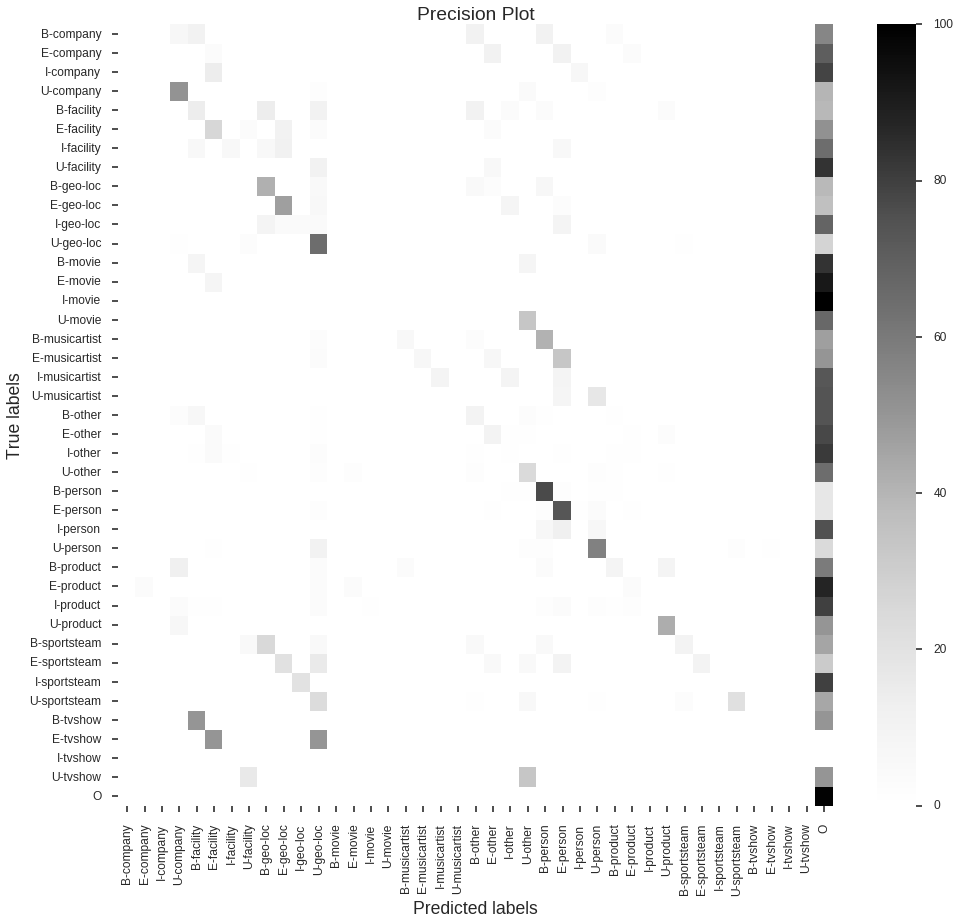

In [86]:
cm = plot_cm(y_test, y_pred, labels=sorted_labels + ["O"])

(41, 41)


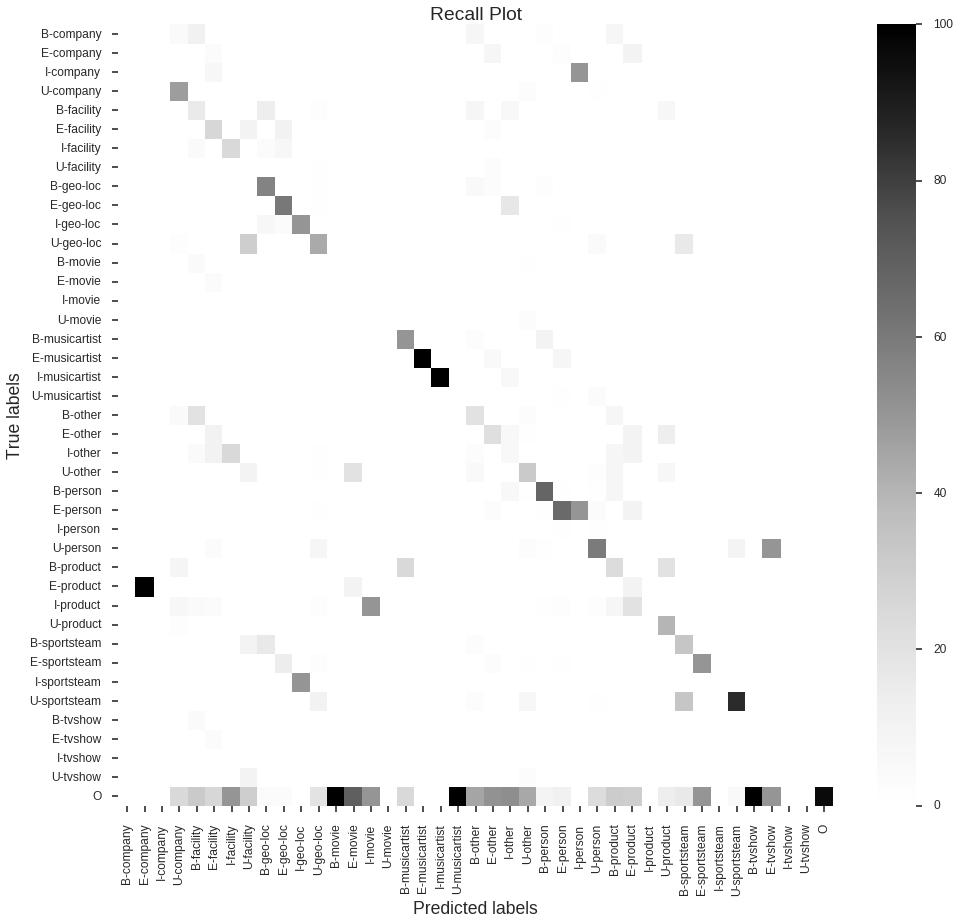

In [87]:
cm = plot_cm(y_test, y_pred, labels=sorted_labels + ["O"], axis=0)

## Dev evaluation

In [88]:
print_sequences(dev_sequences, y_pred, "dev_wv.crf.bieou.tsv")

Done


In [89]:
## FINAL MODEL
! cat dev_wv.crf.bieou.tsv | tr '\t' ' ' | perl -ne '{chomp;s/\r//g;print $_,"\n";}' | python data/conlleval.py

processed 23050 tokens with 937 phrases; found: 748 phrases; correct: 343.
accuracy:  94.34%; precision:  45.86%; recall:  36.61%; FB1:  40.71
          company: precision:  46.94%; recall:  31.94%; FB1:  38.02  49
         facility: precision:  10.81%; recall:   8.70%; FB1:   9.64  37
          geo-loc: precision:  45.45%; recall:  58.64%; FB1:  51.21  209
            movie: precision:   0.00%; recall:   0.00%; FB1:   0.00  8
      musicartist: precision:  28.57%; recall:   3.51%; FB1:   6.25  7
            other: precision:  26.45%; recall:  17.88%; FB1:  21.33  121
           person: precision:  61.39%; recall:  65.16%; FB1:  63.22  259
          product: precision:  24.14%; recall:  15.22%; FB1:  18.67  29
       sportsteam: precision:  77.78%; recall:  20.00%; FB1:  31.82  27
           tvshow: precision:   0.00%; recall:   0.00%; FB1:   0.00  2


In [90]:
print_sequences(dev_sequences, y_pred, "dev_wv.crf.bieou.notypes.tsv", notypes=True)

Done


In [91]:
## FINAL MODEL
! cat dev_wv.crf.bieou.notypes.tsv | tr '\t' ' ' | perl -ne '{chomp;s/\r//g;print $_,"\n";}' | python data/conlleval.py

processed 23050 tokens with 937 phrases; found: 738 phrases; correct: 461.
accuracy:  95.29%; precision:  62.47%; recall:  49.20%; FB1:  55.04
                 : precision:  62.47%; recall:  49.20%; FB1:  55.04  738


## Final Test data evaluation

In [92]:
y_pred = crf.predict(X_test_final)
print "Dev accuracy: ", metrics.flat_f1_score(y_test_final, y_pred, 
                      average='weighted', labels=labels)

report = metrics.flat_classification_report(
    y_test_final, y_pred, labels=sorted_labels, digits=3
)
display(classification_report_to_df(report))

Dev accuracy:  0.247369351833


,class,precision,recall,f1-score,support
0,B-company,0.600,0.033,0.062,184
1,E-company,0.600,0.034,0.065,176
2,I-company,1.000,0.068,0.128,88
3,U-company,0.625,0.194,0.296,438
4,B-facility,0.533,0.182,0.271,220
5,E-facility,0.524,0.196,0.286,219
6,I-facility,0.680,0.116,0.198,147
7,U-facility,0.333,0.061,0.103,33
8,B-geo-loc,0.687,0.538,0.603,212
9,E-geo-loc,0.696,0.573,0.629,192


In [93]:
print_sequences(test_sequences, y_pred, "test_wv.crf.bieou.tsv")

Done


In [94]:
## FINAL MODEL
! cat test_wv.crf.bieou.tsv | tr '\t' ' ' | perl -ne '{chomp;s/\r//g;print $_,"\n";}' | python data/conlleval.py

processed 61908 tokens with 3489 phrases; found: 1661 phrases; correct: 839.
accuracy:  91.84%; precision:  50.51%; recall:  24.05%; FB1:  32.58
          company: precision:  63.01%; recall:  14.79%; FB1:  23.96  146
         facility: precision:  43.33%; recall:  15.42%; FB1:  22.74  90
          geo-loc: precision:  66.38%; recall:  52.71%; FB1:  58.76  702
            movie: precision:   0.00%; recall:   0.00%; FB1:   0.00  9
      musicartist: precision:  20.00%; recall:   1.04%; FB1:   1.98  10
            other: precision:  29.14%; recall:   8.63%; FB1:  13.32  175
           person: precision:  40.44%; recall:  33.88%; FB1:  36.87  408
          product: precision:  18.31%; recall:   5.28%; FB1:   8.20  71
       sportsteam: precision:  24.39%; recall:   6.80%; FB1:  10.64  41
           tvshow: precision:  11.11%; recall:   3.03%; FB1:   4.76  9


In [95]:
print_sequences(test_sequences, y_pred, "test_wv.crf.bieou.notypes.tsv", notypes=True)

Done


In [96]:
## FINAL MODEL
! cat test_wv.crf.bieou.notypes.tsv | tr '\t' ' ' | perl -ne '{chomp;s/\r//g;print $_,"\n";}' | python data/conlleval.py

processed 61908 tokens with 3489 phrases; found: 1643 phrases; correct: 1078.
accuracy:  92.77%; precision:  65.61%; recall:  30.90%; FB1:  42.01
                 : precision:  65.61%; recall:  30.90%; FB1:  42.01  1643


## Run this cell to get the no-types evaluation of the submitted solution


```
%%bash
sed -s 's/\([BI]\)\-[a-z\-]\+/\1/g' dev.crf.bieou.tsv | tr '\t' ' ' | perl -ne '{chomp;s/\r//g;print $_,"\n";}' | python data/conlleval.py
```

## Final Run

Paper submission models are stored in `WNUT_NER_2016_IM_models.txt`


### SGD + dictionary + word_vec + brown_clusters + clark_clusters + wv_clusters + regex


```

X_train = [sent2features(s, vocab=None,
                         dict_features=dict_features, vocab_presence_only=False,
                         window=2, interactions=True, dict_interactions=False,
                         lowercase=True, dropout=0, word2vec_model=model_glove,
                        cluster_vocabs=[
            cluster_vocab,
            cluster_vocab_clark,
            cluster_vocab_wv
        ],
              extra_features=get_global_sequence_features(
            s, #cluster_vocabs=cluster_vocab, word2vec_model=model_glove,
        #predictions=p
        ))
           for s, p in zip(train_sequences, predictions_train)]


processed 23050 tokens with 937 phrases; found: 749 phrases; correct: 354.
accuracy:  94.60%; precision:  47.26%; recall:  37.78%; FB1:  41.99
          company: precision:  38.00%; recall:  26.39%; FB1:  31.15  50
         facility: precision:  20.00%; recall:   8.70%; FB1:  12.12  20
          geo-loc: precision:  44.21%; recall:  66.05%; FB1:  52.97  242
            movie: precision:  37.50%; recall:  16.67%; FB1:  23.08  8
      musicartist: precision:   0.00%; recall:   0.00%; FB1:   0.00  3
            other: precision:  27.64%; recall:  18.99%; FB1:  22.52  123
           person: precision:  65.59%; recall:  66.39%; FB1:  65.99  247
          product: precision:  25.00%; recall:  15.22%; FB1:  18.92  28
       sportsteam: precision:  73.91%; recall:  16.19%; FB1:  26.56  23
           tvshow: precision:  20.00%; recall:  12.50%; FB1:  15.38  5
           
           
processed 23050 tokens with 937 phrases; found: 741 phrases; correct: 476.
accuracy:  95.71%; precision:  64.24%; recall:  50.80%; FB1:  56.73
                 : precision:  64.24%; recall:  50.80%; FB1:  56.73  741           
```


## Best performance

### SGD: Brown clusters + Word embeddings (Glove + conditied to text) + Regex + Dict features
```
processed 23050 tokens with 937 phrases; found: 790 phrases; correct: 374.
accuracy:  94.58%; precision:  47.34%; recall:  39.91%; FB1:  43.31
          company: precision:  41.07%; recall:  31.94%; FB1:  35.94  56
         facility: precision:  27.50%; recall:  23.91%; FB1:  25.58  40
          geo-loc: precision:  46.90%; recall:  65.43%; FB1:  54.64  226
            movie: precision:   0.00%; recall:   0.00%; FB1:   0.00  8
      musicartist: precision:  10.00%; recall:   3.51%; FB1:   5.19  20
            other: precision:  53.16%; recall:  23.46%; FB1:  32.56  79
           person: precision:  56.34%; recall:  65.57%; FB1:  60.61  284
          product: precision:  20.00%; recall:  17.39%; FB1:  18.60  40
       sportsteam: precision:  84.00%; recall:  20.00%; FB1:  32.31  25
           tvshow: precision:   8.33%; recall:  12.50%; FB1:  10.00  12

```

### SGD: Brown clusters (+ conditioned on tweets) + Clark clusters (only on tweets) + Word embeddings (Glove + conditied to text) + Regex + Dict features
```
processed 23050 tokens with 937 phrases; found: 798 phrases; correct: 366.
accuracy:  94.25%; precision:  45.86%; recall:  39.06%; FB1:  42.19
          company: precision:  35.59%; recall:  29.17%; FB1:  32.06  59
         facility: precision:  26.32%; recall:  21.74%; FB1:  23.81  38
          geo-loc: precision:  50.74%; recall:  63.58%; FB1:  56.44  203
            movie: precision:   0.00%; recall:   0.00%; FB1:   0.00  5
      musicartist: precision:   0.00%; recall:   0.00%; FB1:   0.00  8
            other: precision:  34.90%; recall:  29.05%; FB1:  31.71  149
           person: precision:  58.62%; recall:  62.70%; FB1:  60.59  261
          product: precision:  16.67%; recall:  15.22%; FB1:  15.91  42
       sportsteam: precision:  64.29%; recall:  17.14%; FB1:  27.07  28
           tvshow: precision:  40.00%; recall:  25.00%; FB1:  30.77  5
```

### SGD: Brown clusters (+ conditioned on tweets) + Word embeddings (Glove + conditied to text) + Regex + Dict features
```
processed 23050 tokens with 937 phrases; found: 807 phrases; correct: 367.
accuracy:  94.15%; precision:  45.48%; recall:  39.17%; FB1:  42.09
          company: precision:  38.18%; recall:  29.17%; FB1:  33.07  55
         facility: precision:  23.53%; recall:  17.39%; FB1:  20.00  34
          geo-loc: precision:  51.76%; recall:  63.58%; FB1:  57.06  199
            movie: precision:   0.00%; recall:   0.00%; FB1:   0.00  7
      musicartist: precision:   0.00%; recall:   0.00%; FB1:   0.00  8
            other: precision:  32.34%; recall:  30.17%; FB1:  31.21  167
           person: precision:  59.30%; recall:  62.70%; FB1:  60.96  258
          product: precision:  15.56%; recall:  15.22%; FB1:  15.38  45
       sportsteam: precision:  65.52%; recall:  18.10%; FB1:  28.36  29
           tvshow: precision:  40.00%; recall:  25.00%; FB1:  30.77  5
```



### SGD: Brown clusters + context words + Word embeddings (Glove + conditied to text) + Regex + Dict features

```
processed 23050 tokens with 937 phrases; found: 763 phrases; correct: 367.
accuracy:  94.53%; precision:  48.10%; recall:  39.17%; FB1:  43.18
          company: precision:  47.83%; recall:  30.56%; FB1:  37.29  46
         facility: precision:  30.00%; recall:  26.09%; FB1:  27.91  40
          geo-loc: precision:  48.17%; recall:  64.81%; FB1:  55.26  218
            movie: precision:   0.00%; recall:   0.00%; FB1:   0.00  5
      musicartist: precision:   0.00%; recall:   0.00%; FB1:   0.00  10
            other: precision:  39.64%; recall:  24.58%; FB1:  30.34  111
           person: precision:  60.70%; recall:  63.93%; FB1:  62.28  257
          product: precision:  25.00%; recall:  17.39%; FB1:  20.51  32
       sportsteam: precision:  60.00%; recall:  17.14%; FB1:  26.67  30
           tvshow: precision:  14.29%; recall:  25.00%; FB1:  18.18  14
```

### second best

```
processed 23050 tokens with 937 phrases; found: 845 phrases; correct: 337.
accuracy:  92.64%; precision:  39.88%; recall:  35.97%; FB1:  37.82
          company: precision:  48.89%; recall:  30.56%; FB1:  37.61  45
         facility: precision:  17.50%; recall:  15.22%; FB1:  16.28  40
          geo-loc: precision:  50.52%; recall:  60.49%; FB1:  55.06  194
            movie: precision:   0.00%; recall:   0.00%; FB1:   0.00  9
      musicartist: precision:   0.00%; recall:   0.00%; FB1:   0.00  13
            other: precision:  15.10%; recall:  20.67%; FB1:  17.45  245
           person: precision:  65.47%; recall:  59.84%; FB1:  62.53  223
          product: precision:  22.22%; recall:  17.39%; FB1:  19.51  36
       sportsteam: precision:  65.52%; recall:  18.10%; FB1:  28.36  29
           tvshow: precision:   0.00%; recall:   0.00%; FB1:   0.00  11
```

### LBFGS - only brown clusters + wordvec + regex + dict

```
processed 23050 tokens with 937 phrases; found: 972 phrases; correct: 348.
accuracy:  93.26%; precision:  35.80%; recall:  37.14%; FB1:  36.46
          company: precision:  28.95%; recall:  30.56%; FB1:  29.73  76
         facility: precision:  19.64%; recall:  23.91%; FB1:  21.57  56
          geo-loc: precision:  40.48%; recall:  62.96%; FB1:  49.28  252
            movie: precision:   0.00%; recall:   0.00%; FB1:   0.00  12
      musicartist: precision:   0.00%; recall:   0.00%; FB1:   0.00  21
            other: precision:  25.00%; recall:  25.14%; FB1:  25.07  180
           person: precision:  54.55%; recall:  56.56%; FB1:  55.53  253
          product: precision:  11.11%; recall:  15.22%; FB1:  12.84  63
       sportsteam: precision:  43.48%; recall:  19.05%; FB1:  26.49  46
           tvshow: precision:  23.08%; recall:  37.50%; FB1:  28.57  13
```
